## Term Project

### Fine-Tuning

LLM fine-tuning is a technique to adjust the wights of a LLM to make it generate tailored response for a specific task without the hassle of training and building a LLM from scratch. Fine tuning requires preparation of the task specific dataset, fine tune the model and then evaluate the performance of the fine-tuned model for qualitative and quantitative metrics.

``` Prepare dataset >> Load dataset to OpenAI >> Start Fine Tuning Job >> Run test```

In the assignment, we are fine-tuning Open AI `gpt-4o-mini` model so that it can act as an assistant which replies answers with emojis but instead of emoji it should reply **with words**.

For example, if we ask about about a smiling face instead of 😀, it must respond with `(grinningface)`.

1. Prepare Dataset

Open AI fine tuning expects jsonl format with each line containing example with messages similar to [chat completion api format][1] (example below). It is a list of messages where each message has a role, content, and optional name. 

```
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}
```
Data prepration is not required for this assignment because we are using already curated dataset from the author (Bahree, 2024) that follows the above jsonl format.

[1]:https://platform.openai.com/docs/api-reference/chat/createm
[2]:https://github.com/bahree/GenAIBook/tree/main/chapters/ch09/data

In [22]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import tiktoken  
import os
import pprint
import time
import pandas as pd
import jsonlines
import json

In [23]:
df = pd.read_csv("./datasets/train.csv")

In [24]:
df.head()

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In order to keep the cost of fine tuning low the records having very large text will be dropped. Before dropping such text it is better to see the distribution of lengths to make a good estimate on how long text should be good estimate.

In [25]:
#claculate the length of texts
df["context_length"] = df["Context"].str.len()
df["response_length"] = df["Response"].str.len()

Five point summary of context_length
 count    3512.000000
mean      282.652335
std       246.213884
min        25.000000
25%       147.000000
50%       232.000000
75%       348.250000
max      2703.000000
Name: context_length, dtype: float64


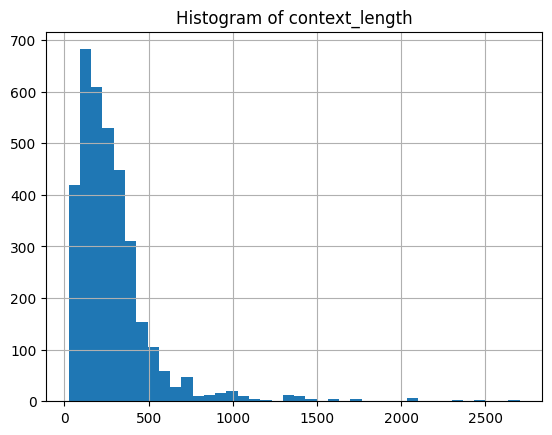

Five point summary of response_length
 count     3508.000000
mean      1027.238883
std       1010.811425
min          1.000000
25%        534.000000
50%        836.000000
75%       1274.000000
max      32739.000000
Name: response_length, dtype: float64


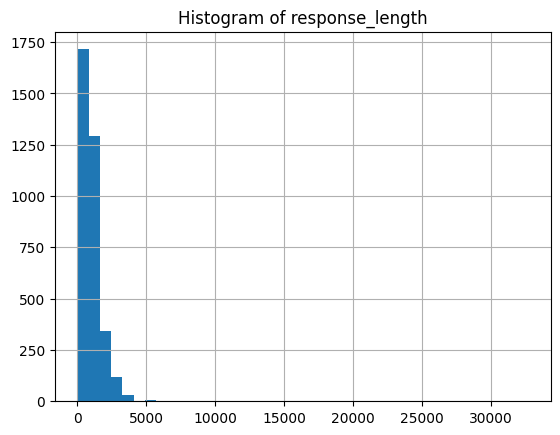

In [26]:
for cols in ["context_length", "response_length"]:
    df[cols].hist(bins=40)
    print(f"Five point summary of {cols}\n {df[cols].describe()}")
    plt.title(f"Histogram of {cols}")
    plt.show()

Both the Question and th Response charcter length is heavily right skewed. hence, it will be a good estimate to discard records beyond 1.5IQR of Q3, i.e. Similarly very small responses may not be good response to the questions. It is a good estimate that any response less that 100 characters will not be a good response.
```
lower limit: 100
upper limit: Q3 + 1.5IQR

```

In [43]:
def drop_large_txt_records(df):
    for cols in ["context_length", "response_length"]:
        q1 = df[cols].quantile(0.25)
        q3 = df[cols].quantile(0.75)
        IQR = q3-q1
        upper_limit = q3 + 1.5*IQR
        print(f"Upper Limit for {cols}: {upper_limit}")
        print(f"Shape before dropping records: {df.shape}")
        df = df.drop(df[df[cols] < 100].index)
        df = df.drop(df[df[cols] > upper_limit].index)
        print(f"Shape after dropping records: {df.shape}")
    return df

In [44]:
df_copy = df.copy()

df_no_outliers = drop_large_txt_records(df_copy)

Upper Limit for context_length: 650.125
Shape before dropping records: (3512, 4)
Shape after dropping records: (2797, 4)
Upper Limit for response_length: 2371.75
Shape before dropping records: (2797, 4)
Shape after dropping records: (2638, 4)


Five point summary of context_length
 count    2638.000000
mean      271.602729
std       120.175790
min       102.000000
25%       167.000000
50%       254.000000
75%       348.000000
max       646.000000
Name: context_length, dtype: float64


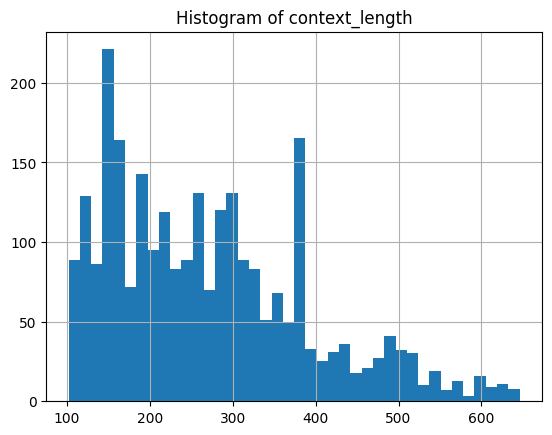

Five point summary of response_length
 count    2636.000000
mean      918.025417
std       496.460766
min       101.000000
25%       538.000000
50%       820.000000
75%      1213.250000
max      2357.000000
Name: response_length, dtype: float64


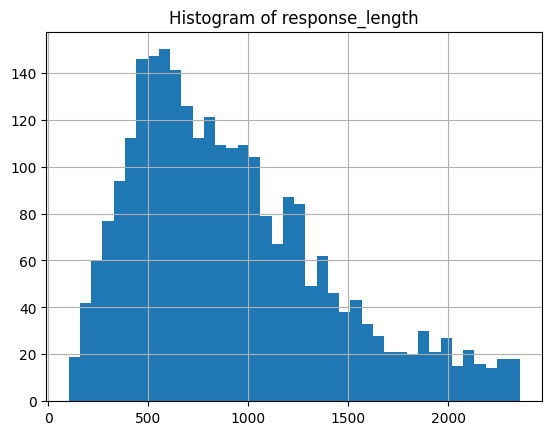

In [45]:
# Check distribution after removing outliers
for cols in ["context_length", "response_length"]:
    df_no_outliers[cols].hist(bins=40)
    print(f"Five point summary of {cols}\n {df_no_outliers[cols].describe()}")
    plt.title(f"Histogram of {cols}")
    plt.show()

The data looks much better after dopping the large length and small length records.

In [66]:
# Add unique id for each rows
df_no_outliers["id"] = df_no_outliers.index

In [67]:
df_no_outliers.head()

,Context,Response,context_length,response_length,id
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",328,961.0,0
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",328,2082.0,1
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,328,299.0,2
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,328,844.0,3
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,328,337.0,4


#### Standardization

In [133]:
# import modules for text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import string

In [134]:
# this function removes stopwords from input text
    
def custom_standardization_fn(text):
    lowercase_string = text.lower()
    regex_punc = re.sub(
        f"[0-9{re.escape(string.punctuation)}]", lambda match: "" , lowercase_string)
    regex_clean = re.sub(
        f"[\\r\\t\\n]", lambda match: " " , regex_punc)

    stop_words = stopwords.words("english")
    tokenized_words = word_tokenize(regex_clean)
    stop_word_removed_tokens = [word for word in tokenized_words if word not in stop_words]
    stopword_removed_string = " ".join([word for word in tokenized_words if word not in stop_words])
    # lemmatize
    wnl = WordNetLemmatizer()
    return " ".join([wnl.lemmatize(words) for words in stop_word_removed_tokens])

In [136]:
df_no_outliers["Context"] = df_no_outliers["Context"].apply(custom_standardization_fn)

### Clustering questions

In [49]:
# !pip install sentence-transformers

In [51]:
from sentence_transformers import SentenceTransformer, util
import tqdm

In [53]:
# Model for computing sentence embeddings. We use one trained for similar questions detection
model = SentenceTransformer("all-MiniLM-L6-v2")

In [142]:
max_corpus_size = 3000

In [143]:
# Get all unique sentences from the file
corpus_sentences = set()
for row in df_no_outliers.iterrows():
    corpus_sentences.add(f'id:{row[1]["id"]}text:{row[1]["Context"]}')
    # corpus_sentences.add(row["question2"])
    if len(corpus_sentences) >= max_corpus_size:
        break

In [144]:
for sent in corpus_sentences:
    print(sent)
    break

id:3349text:early still live parent cant afford live alone mother say live roof follow rule trying control life


In [145]:
corpus_sentences = list(corpus_sentences)
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(corpus_sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Encode the corpus. This might take a while


Batches: 100%|██████████████████████████████████| 42/42 [00:03<00:00, 10.91it/s]


In [148]:
print("Start clustering")
start_time = time.time()

# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least 25 elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=3, threshold=0.001)

print(f"Clustering done after {time.time() - start_time:.2f} sec")

Start clustering
Clustering done after 6.47 sec


In [149]:
# Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(clusters):
    print(f"\nCluster {i + 1}, #{len(cluster)} Elements ")
    # for sentence_id in cluster[0:3]:
    #     print("\t", corpus_sentences[sentence_id])
    # print("\t", "...")
    # for sentence_id in cluster[-3:]:
    #     print("\t", corpus_sentences[sentence_id])


Cluster 1, #2638 Elements 


### K means

In [93]:
from sklearn.cluster import KMeans

In [90]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [153]:
corpus = df_no_outliers["Context"].to_list()
corpus_embeddings_kmeans = embedder.encode(corpus)

In [156]:
# Perform kmean clustering
num_clusters = 30
inertia = []
for k in range(1, num_clusters):
    clustering_model_kmean = KMeans(n_clusters=k)
    clustering_model_kmean.fit(corpus_embeddings_kmeans)
    # cluster_assignment = clustering_model.labels_
    inertia.append(clustering_model_kmean.inertia_)

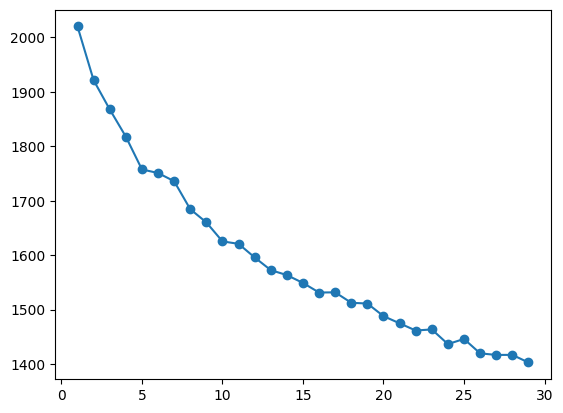

In [157]:
plt.plot(range(1, num_clusters), inertia, marker='o')
plt.show()

In [164]:
# Perform kmean clustering
num_clusters = 10
clustering_model_kmean = KMeans(n_clusters=num_clusters)
clustering_model_kmean.fit(corpus_embeddings_kmeans)
cluster_assignment_kmeans = clustering_model_kmean.labels_

In [165]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment_kmeans):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

In [170]:
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i + 1)
    print(len(cluster))
    print(cluster[0])


Cluster  1
498
selfharm stop awhile see something sad depressing automatically want selfharm
Cluster  2
429
im going thing feeling barely sleep nothing think im worthless shouldnt ive never tried contemplated suicide ive always wanted fix issue never get around change feeling worthless everyone
Cluster  3
267
tried telling husband depressed ignored said youre always sad depressed picked phone ignored said please dont exaggerate isnt true said whatever babe want sad get take seriously
Cluster  4
405
im teenager dad jail last five year tough mom really try give normal life two sister brother feel like took upon parent role im second youngest im stable mother sister say im overdramatic ’ hurt keep breaking
Cluster  5
268
year ago making love wife known reason lost erection im early problem become frequent causing major problem ego diminishing self esteem resulted ongoing depression tearing apart marriage devastated find cause issue attracted wife want express bedroom like used could causi

In [161]:
cluster_assignment_kmeans

array([16, 16, 16, ...,  2, 22,  1], shape=(2638,), dtype=int32)

In [7]:
df = df.sample(n=500, random_state=42)

In [8]:
val_df = df.sample(frac=0.1, random_state=42)

In [9]:
train_df = df.drop(val_df.index)

In [10]:
train_df.shape, val_df.shape

((450, 2), (50, 2))

In [11]:
training_data_file = "./datasets/training_file.jsonl"
validation_data_file = "./datasets/validation_file.jsonl"

In [12]:
# get the encoding for gpt-4o-mini-2024-07-18
encoding = tiktoken.encoding_for_model("gpt-4o-mini-2024-07-18")
print(f"Token encoding for gpt-4o-mini is : {encoding.name}")

Token encoding for gpt-4o-mini is : o200k_base


##### Token validation

`gpt-4o-mini-2024-07-18` will be used as foundational model for fine-tuning, so to get the correct token counts, the encoding corresponding to this model must be used.

In [21]:
def create_jsonl_file(file_path,df):
    system_message = "You are an assistant that helps answer mental health question."
    system_message_tokens = len(encoding.encode(system_message))
    with jsonlines.open(file_path,mode="w") as writer:
        for row in df.iterrows():
            context_tokens = len(encoding.encode(row[1]["Context"]))
            assistant_tokens = len(encoding.encode(row[1]["Response"]))
            if (system_message_tokens+context_tokens+assistant_tokens) < 500:
                message_dict = {
                    "messages":[
                        {"role":"system","content":system_message},
                        {"role":"user","content":row[1]["Context"]},
                        {"role": "assistant", "content":row[1]["Response"]}
                    ]
                }
                writer.write((message_dict))

In [22]:
create_jsonl_file(training_data_file, train_df)
create_jsonl_file(validation_data_file, val_df)

In [23]:
MAX_TOKENS = 65536

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 1000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 5

##### Basic data check

In [24]:
def basic_checks(data_file):
    try:
        with open(data_file, "r", encoding="utf-8") as f:
            dataset = [json.loads(line) for line in f]

        print(f"Basic checks for file {data_file}:")
        print("Count of examples in dataset:", len(dataset))
        print("First example:")
        for message in dataset[0]["messages"]:
            print(message)
        return True
    except FileNotFoundError as e:
        print(f"File not found error occurred in file {data_file}: {e}")
        return False
    except json.JSONDecodeError as e:
        print(f"JSON decoding error occurred in file {data_file}: {e}")
        return False
    except Exception as e:
        print(f"An error occurred in file {data_file}: {e}")
        return False

In [25]:
if not basic_checks(training_data_file):
    print(f"Error in Trainingfile {training_data_file}")
if not basic_checks(validation_data_file):
    print(f"Error in Validation file {validation_data_file}")

Basic checks for file ./datasets/training_file.jsonl:
Count of examples in dataset: 404
First example:
{'role': 'system', 'content': 'You are an assistant that helps answer mental health question.'}
{'role': 'user', 'content': 'I have no real friends. I have a girlfriend who irritates me but loves me to death. I push her away and pushes me away. We’re going through a breakup, and I have nobody.'}
{'role': 'assistant', 'content': 'Having time all to yourself may be necessary so you have time to reflect on your own identity and values, become more clear on what matters most to you, and with this increased self-understanding, be able to attract people who will feel like satisfying friends.Having a relationship with someone whom you push away and are pushed away, with someone who is irritating, seems to have limited benefit for each of you.Maybe you are together from fear of being alone, and being alone is exactly what you may now need in your life in order to draw more favorable people to

The training and validation files have passed the check for `jsonl` format 

In [26]:
def format_checks(dataset, filename):
    # Initialize a dictionary, used to track format errors
    format_errors = defaultdict(int)

    # Iterate over each example in the dataset
    for ex in dataset:
        # Check if the example is a dictionary, if not 
        # increment the corresponding error count
        if not isinstance(ex, dict):
            format_errors["data_type"] += 1
            continue

        # Check if the example has a "messages" key, 
        # if not increment the corresponding error count
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue

        # Iterate over each message in the messages list
        for message in messages:
            # Check if the message has "role" and "content" keys,
            # if not increment the corresponding error count
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1

            # Check if the message has any unrecognized keys,
            # if so increment the corresponding error count
            if any(k not in ("role", "content", "name", "function_call") for k in message):
                format_errors["message_unrecognized_key"] += 1

            # Check if the role of the message is one of the recognized
            # roles, if not increment the corresponding error count
            if message.get("role", None) not in (
                "system",
                "user",
                "assistant",
                "function",
            ):
                format_errors["unrecognized_role"] += 1

            # Check if the message has either content or a function call,
            # and if the content is a string, if not increment the
            # corresponding error count
            content = message.get("content", None)
            function_call = message.get("function_call", None)
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1

        # Check if there is at least one message with the role "assistant",
        # if not increment the corresponding error count
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1

    # If there are any format errors, print them and return False
    if format_errors:
        print(f"Formatting errors found in file {filename}:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
        return False
    print(f"No formatting errors found in file {filename}")
    return True

In [27]:
# check example format are correct for training file
with open(training_data_file, "r", encoding="utf-8") as f:
    train_dataset = [json.loads(line) for line in f]
    if not format_checks(train_dataset, training_data_file):
        print(f"Error in training examples format validation for {training_data_file}")

No formatting errors found in file ./datasets/training_file.jsonl


In [28]:
# check example format are correct for validation file
with open(validation_data_file, "r", encoding="utf-8") as f:
    valid_dataset = [json.loads(line) for line in f]
    if not format_checks(valid_dataset, validation_data_file):
        print(f"Error in training examples format validation for {validation_data_file}")

No formatting errors found in file ./datasets/validation_file.jsonl


Fine tuning is billed by the `number of tokens` used in the training examples. Hence, it is always advisable to estimate the numbers tokens in the training examples and how many total tokens will be used in the fine-tuning. This will provide a rough estimate about the cost of the fine-tuning to avoid any surprises.

In [29]:
# Print the number of tokens in the messages
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

# print the number of tokens in the assistant messages
def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens


In [30]:
# Estimate the number of tokens that will be charged for during training
def estimate_tokens(dataset, assistant_tokens):
    # Set the initial number of epochs to the target epochs
    n_epochs = TARGET_EPOCHS
    
    # Get the number of examples in the dataset
    n_train_examples = len(dataset)

    # If the examples total is less than the minimum target
    # adjust the epochs to ensure we have enough examples for
    # training
    if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
        n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
    
    # If the  number of examples is more than the maximum target
    # adjust the  epochs to ensure we don't exceed the maximum 
    # for training
    elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
        n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

    # Calculate the total number of tokens in the dataset
    # n_billing_tokens_in_dataset = sum(min(MAX_TOKENS, length) for length in assistant_tokens)
    n_billing_tokens_in_dataset = sum(min(MAX_TOKENS, length) for length in assistant_tokens)

    # Print the total token count that will be charged during training
    print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")

    # Print the default number of epochs for training
    print(f"You will train for {n_epochs} epochs on this dataset")

    # Print the total number of tokens that will be charged during training
    print(f"You will be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

    # If the total token count exceeds the maximum tokens, print a warning 
    # if n_billing_tokens_in_dataset > MAX_TOKENS:
    #     print(f"WARNING: Your dataset contains examples longer than 4K tokens by {n_billing_tokens_in_dataset - MAX_TOKENS} tokens.")
    #     print("You will be charged for the full length of these examples during training, but only the first 4K tokens will be used for training.")
    return n_billing_tokens_in_dataset

In [31]:
with open(training_data_file, "r", encoding="utf-8") as f:
    train_dataset = [json.loads(line) for line in f]
with open(validation_data_file, "r", encoding="utf-8") as f:
    valid_dataset = [json.loads(line) for line in f]

In [32]:
total_tokens = []
assistant_tokens = []
for example in train_dataset:
    messages = example.get("messages", {})
    total_tokens.append(num_tokens_from_messages(messages))
    assistant_tokens.append(num_assistant_tokens_from_messages(messages))

In [33]:
tokens_used_in_traiing = estimate_tokens(train_dataset, total_tokens)

Dataset has ~99671 tokens that will be charged for during training
You will train for 2 epochs on this dataset
You will be charged for ~199342 tokens


In [34]:
print(f"Estimated Cost: $ {(3/1000000)*tokens_used_in_traiing*TARGET_EPOCHS}")

Estimated Cost: $ 0.8970390000000001


OpenAI doesnot charge for validation tokens, so only training tokens are charged. Current pricing is \$3 per 1M tokens. For the above training dataset the estimated cost is `$0.18`

2. Upload training file to Open AI

Open AI requires the training and validation file to be uploaded in OpenAI file storage for training.

In [117]:
# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [118]:
# Upload training file
from openai import OpenAI
client = OpenAI()

response = client.files.create(
  file=open(training_data_file, "rb"),
  purpose="fine-tune"
)

In [121]:
print("Uploaded file details\n",response)

Uploaded file details
 FileObject(id='file-LXx1cigU9wSjnU7urUBiUb', bytes=119751, created_at=1737307365, filename='emoji_ft_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [122]:
# upload validation file
validation_file_response = client.files.create(
  file=open(validation_data_file, "rb"),
  purpose="fine-tune"
)
print("Uploaded file details\n",validation_file_response)

Uploaded file details
 FileObject(id='file-KE6JVSUfZSWx8ShsRu1sca', bytes=2053, created_at=1737308416, filename='emoji_ft_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


3. Create and start Fine tuning job

In [123]:
ft_job = client.fine_tuning.jobs.create(
    training_file="file-LXx1cigU9wSjnU7urUBiUb",
    validation_file="file-KE6JVSUfZSWx8ShsRu1sca",
    model="gpt-4o-mini-2024-07-18",
    suffix="emoji-20240122",
    hyperparameters={
        "n_epochs":3
    },
)

print("Finetuning job details:\n", ft_job)

Finetuning job details:
 FineTuningJob(id='ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2', created_at=1737308522, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=3), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-i0HGnyzXyYOGEdOd7p2dDDri', result_files=[], seed=918569459, status='validating_files', trained_tokens=None, training_file='file-LXx1cigU9wSjnU7urUBiUb', validation_file='file-KE6JVSUfZSWx8ShsRu1sca', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=3)), type='supervised'), user_provided_suffix='emoji-20240122')


In [124]:
# List 10 fine-tuning jobs
# ft_job_list = client.fine_tuning.jobs.list()

In [129]:
# Retrieve the state of a fine-tune
start_time = time.time()
while True:
    job = client.fine_tuning.jobs.retrieve("ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2")
    print(job.id, job.status)
    if job.status in ["succeeded","failed","cancelled"]:
        print(f"Job Status: {job.status}")
        print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
        break
    time.sleep(60)

ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 succeeded
Job Status: succeeded
Elapsed time: 97 minutes 1 seconds


Open AI fine tuning job stores the fine-tuning metrics in a result file. The file-id of the resut file can be reference by retriveing the job details in `result_files` attribute.

In [131]:
#retrive the result file id and model name of the model
result = client.fine_tuning.jobs.retrieve("ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2")
print(f"Model id: {result.fine_tuned_model}\nResult file id: {result.result_files}")

Model id: ft:gpt-4o-mini-2024-07-18:personal:emoji-20240122:ArUCgSFs
Result file id: ['file-R7nTQzxG7tD3sR9hQuVwmL']


In [132]:
# Retrive file content from the fine tuning job results
from openai import OpenAI
client = OpenAI()

ft_results = client.files.content(result.result_files[0])

The results are `base-64` encoded, so it needs to be decoded for use and can be downloaded as csv.

In [146]:
import base64

string_bytes = base64.b64decode(ft_results.content)
result_string = string_bytes.decode("ascii")

with open("./results.csv","w") as outfile:
    outfile.write(result_string)
    


Using pandas to read the reslts csv file and plotting the training and validation loss curves

In [147]:
import pandas as pd

In [161]:
df = pd.read_csv("./results.csv")

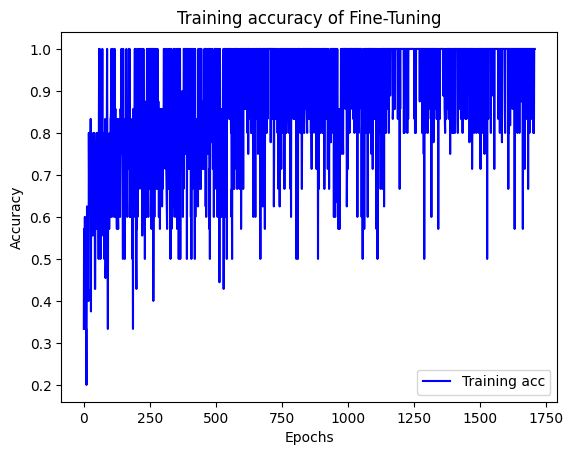

In [164]:
# plot the training accuracy
plt.plot(df["step"], df["train_accuracy"], 'b-', label='Training acc')
plt.title('Training accuracy of Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

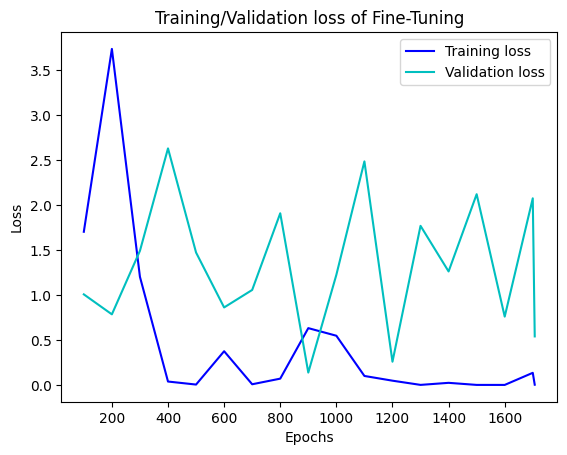

In [169]:
# Plot the training loss and validation loss
plt.plot(df["step"], df["train_loss"], 'b-', label='Training loss')
df = df[df["valid_loss"].notna()]
plt.plot(df["step"], df["valid_loss"], 'c-', label='Validation loss')
plt.title('Training/Validation loss of Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The above curve shows a promising training with training loss high and then stabilizing near zero as number of iterations increses. We do not notice a similar pattern with validation loss as it do not reduce near zero with number of iterations. This may be indication of ovefitting as ideally the training loss and validation loss must be close to each other towards the end of iterations. 

Now the model is ready for testing.

4. Testing the fine tuned model

Prompt 1: Enjoying snowfall

In [3]:
# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [4]:
from openai import OpenAI
client = OpenAI()

#### GPT 4o mini without fine-tuning

In [5]:
messages=[
        {
            "role": "system", 
            "content": f"You are a assistant that generates emojis\n\
            If you donot know the answer, simply state that you donot know."
        },
        {
            "role": "user", 
            "content": f"Q: Enjoying snowfall\nA:"
        }
    ]

In [7]:
chat_response_1_std = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages
)
print(f"Response from GPT 4o mini without fine-tuning:\n {chat_response_1_std.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 ❄️☃️🌨️✨


#### Fine-tuned Model

In [8]:
chat_response_1_fine_tuned = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal:emoji-20240122:ArUCgSFs",
    messages=messages
)
print(f"Response from GPT 4o mini without fine-tuning:\n {chat_response_1_fine_tuned.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 (cloudwithsnow)


In [3]:
# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [4]:
from openai import OpenAI
client = OpenAI()

Prompt 2: Celebrating graduation

#### GPT 4o mini without fine-tuning

In [9]:
messages=[
        {
            "role": "system", 
            "content": f"You are a assistant that generates emojis\n\
            If you donot know the answer, simply state that you donot know."
        },
        {
            "role": "user", 
            "content": f"Q: Celebrating graduation\nA:"
        }
    ]

In [10]:
chat_response_2_std = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages
)
print(f"Response from GPT 4o mini without fine-tuning:\n {chat_response_2_std.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 🎓🎉🎊🥳📚✨


#### Fine-tuned Model

In [11]:
chat_response_2_fine_tuned = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal:emoji-20240122:ArUCgSFs",
    messages=messages
)
print(f"Response from the fine-tuning model:\n {chat_response_2_fine_tuned.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 (graduationcap)
